# Tutorial: Running kNN models

This lab focuses on implementing kNN in R.

## Goals:
* Learn how to use the `knn()` function

This lab draws from the practice sets at the end of Chapter 4 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r."

---
# K-Nearest Neighbors: an intro


It's time to talk about our first non-parametric method: [K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)! This is a pretty straightforward way to classify things. Say you have a bunch of pre-classified items $\bf{x}$, and a new item that you'd like to classify, $x_{new}$. You can look at the K points in $\bf{x}$ that are closest to $x_{new}$, and whichever class is most common among those K points is your predicted classification for the new item, $x_{new}$. 

## Classifying irises

We'll use the `iris` dataset, which we've used in previous tutorials, to demonstrate KNN. As a reminder, the `iris` data set records the length and width of petals and sepals for different species of iris flowers. Let's look at how the different species cluster based on the lengths of their petals and sepals. 

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa


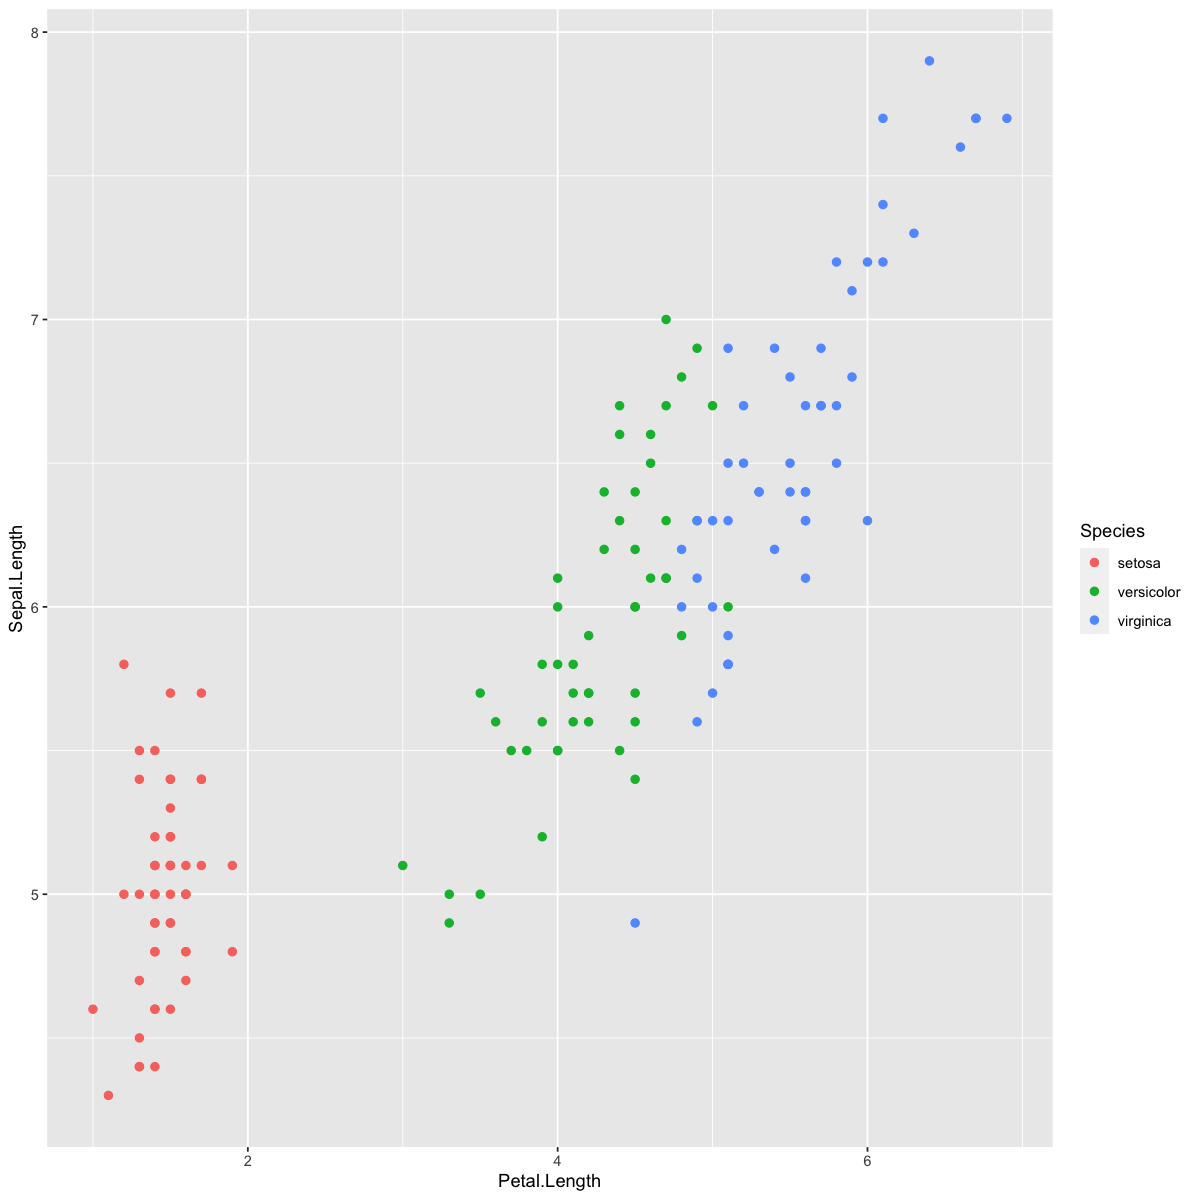

In [9]:
require(tidyverse)
dat <- iris
head(dat)

options(repr.plot.width=10, repr.plot.height=10)
ggplot(dat,aes(x=Petal.Length,y=Sepal.Length,col=Species)) +
 geom_point(size=2)

We can implement KNN in R using the `knn()` function from the `class` library. This takes four inputs: the training predictors (`Sepal.Length` and `Petal.Length`), the testing predictors, the training labels (`Species`) and the value for `K`. 


## Identifying test items

There are 150 observations - let's set aside 30 to be test items. 

In [10]:
# set seed so the notebook will give the same random 30 test items every time
set.seed(1) 

#pull random sample of 30 row indices
test.inds <- sample(1:nrow(dat),30)

# TRUE/FALSE indicator for whether each observation is a test item or not. 
dat$is.test <- 1:nrow(dat) %in% test.inds 
head(dat)



,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,is.test
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
1,5.1,3.5,1.4,0.2,setosa,FALSE
2,4.9,3.0,1.4,0.2,setosa,FALSE
3,4.7,3.2,1.3,0.2,setosa,FALSE
4,4.6,3.1,1.5,0.2,setosa,FALSE
5,5.0,3.6,1.4,0.2,setosa,FALSE
6,5.4,3.9,1.7,0.4,setosa,FALSE


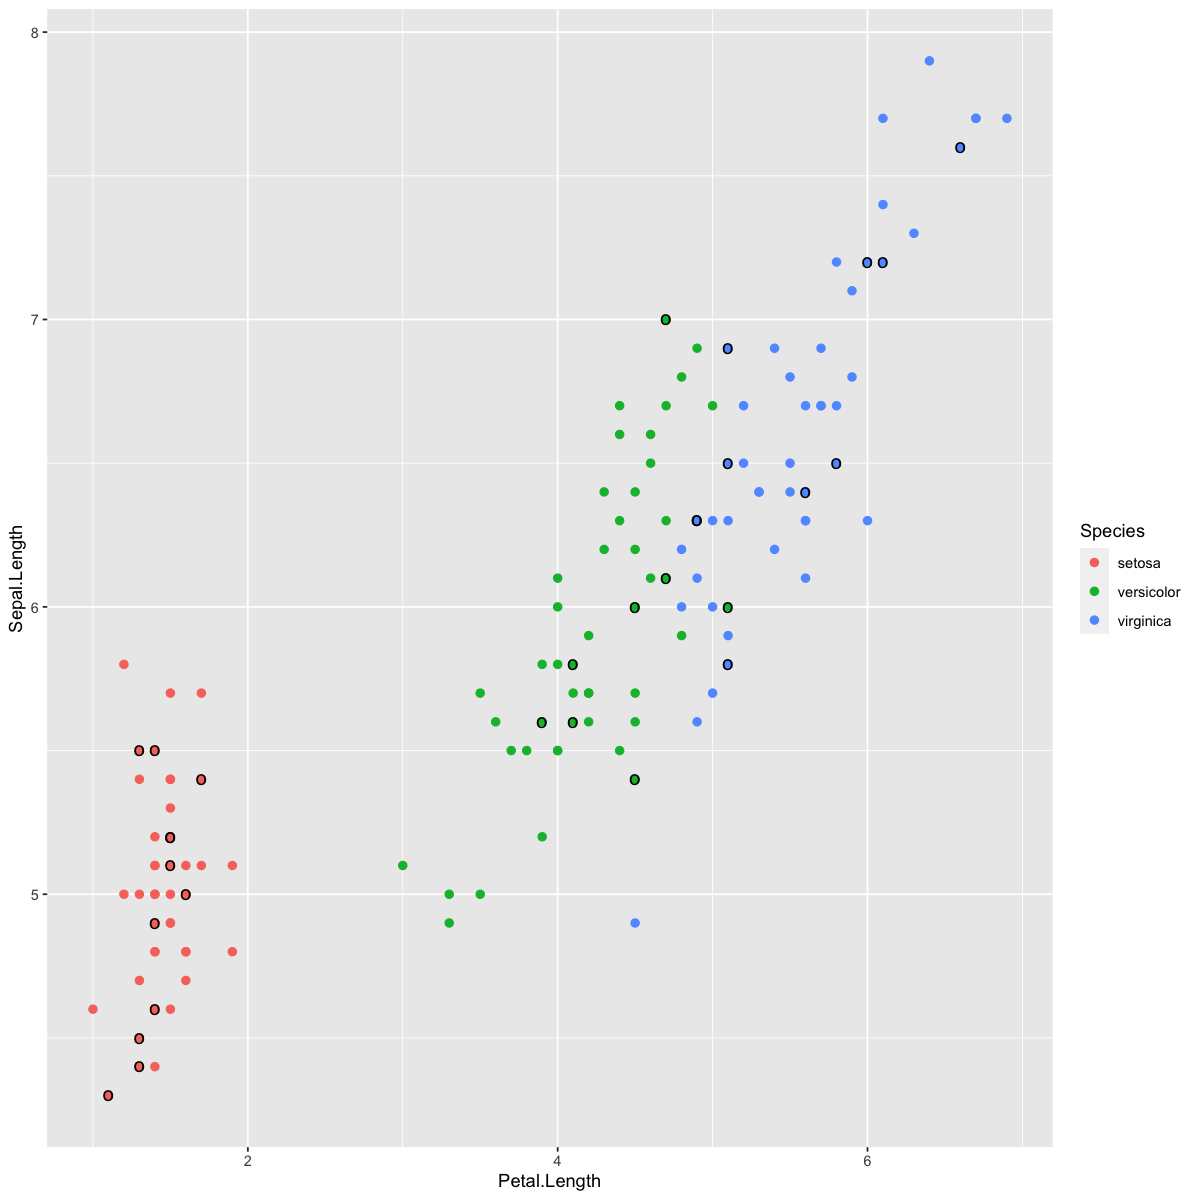

In [11]:
# plot all the data, colored by species
ggplot(dat,aes(x=Petal.Length,y=Sepal.Length,col=Species)) + 
    geom_point(size=2) + 
    # circle the test items:
    geom_point(data=dat[test.inds,],aes(x=Petal.Length,y=Sepal.Length),size=4,color="black",shape="o") 

See if you can predict which of the test items (circled in black above) will be incorrectly classified using the KNN method. 

## Predicting the species using kNN

Now let's try out kNN for `k` = 5. The `knn()` function is part of the `class()` package. As input, it takes a dataframe of the training predictors, training specifications/classifications, the test predictors, and the desired `k`.

In [12]:
library(class)

#training data pulls the "not test" rows
train.preds <- cbind(dat$Petal.Length[-test.inds], dat$Sepal.Length[-test.inds])
train.spec <- dat$Species[-test.inds]
#testing data pulls the test rows
test.preds <- cbind(dat$Petal.Length[test.inds], dat$Sepal.Length[test.inds])

#run knn, returns predictions (specifications)
test.spec.knn <- knn(train.preds, test.preds, train.spec, k = 5)

#print first 10 test specifications
test.spec.knn[1:10]

[1] versicolor virginica  setosa     setosa     versicolor versicolor
 [7] setosa     virginica  virginica  setosa    
Levels: setosa versicolor virginica

## Assessing kNN performance

Let's see how it did at classifying these irises by comparing our `test.spec.knn` object above to the true classifications for the test set. 

In [8]:
head( dat$Species)

[1] setosa setosa setosa setosa setosa setosa
Levels: setosa versicolor virginica

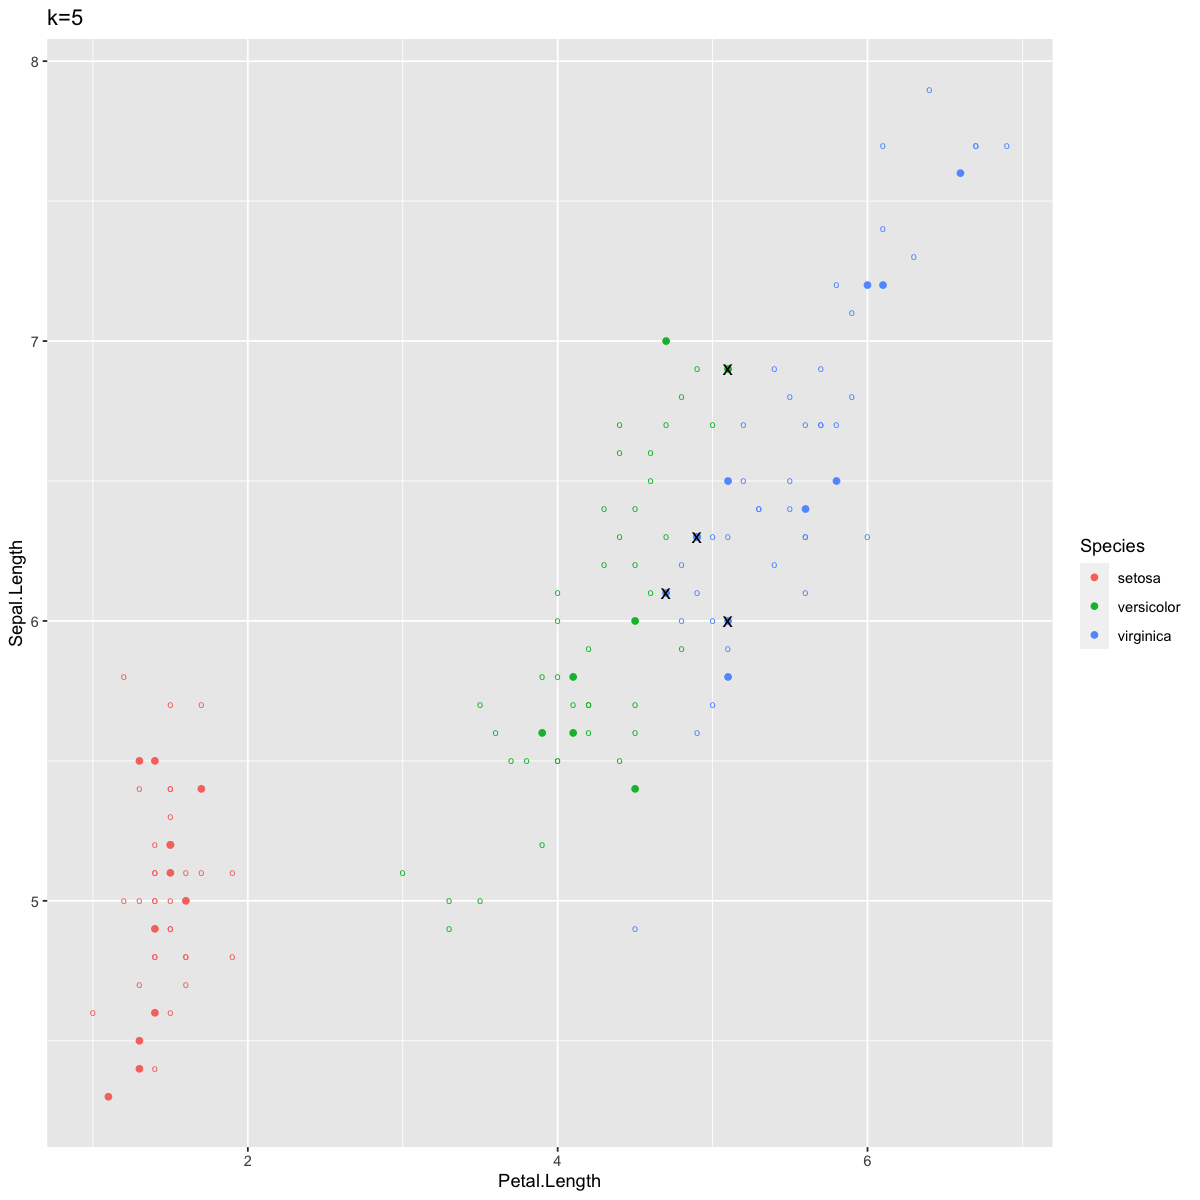

In [7]:
# new variable for each observation's predicted species. 
dat$Species_pred <- dat$Species

# add the KNN predictions for test obs to dataset. (to test indeces)
dat$Species_pred[test.inds] <- test.spec.knn

# in which cases does the observed Species equal the predicted?
dat$KNN_correct <- dat$Species == dat$Species_pred

# Plot
ggplot(dat,aes(x=Petal.Length,y=Sepal.Length,col=Species)) + 
    # Base layer to show training points: 
    geom_point(size=2,shape="o") + 
    # Next layer shows test points' KNN classifications:
    geom_point(data=dat[test.inds,],
               aes(x=Petal.Length,y=Sepal.Length,col=Species_pred)) + 
    # draw "x" over wrong ones.     
    geom_point(data=dat[which(!dat$KNN_correct),],
               aes(x=Petal.Length,y=Sepal.Length),shape="x",col="black",size=4) + 
    ggtitle("k=5")

Since the plotting got a little confusing there, I'll just summarize: the circles are training data, the solid points are test data, colored by their KNN predicted species, and the ones marked with an "x" are incorrect predictions. 

We see only a few points labeled incorrectly. As you might have predicted, these fall along the edge between the blue and green clusters.

We can also visualize our results as a confusion matrix, like we did in the previous tutorial on other classifier methods: 

In [13]:
confusion_df <- data.frame(predicted = test.spec.knn,actual = dat$Species[test.inds])
table(confusion_df)
print("---")
print(paste("Accuracy:", mean(confusion_df$predicted == confusion_df$actual)))

            actual
predicted    setosa versicolor virginica
  setosa         12          0         0
  versicolor      0          6         1
  virginica       0          3         8

[1] "---"
[1] "Accuracy: 0.866666666666667"


Mirroring what we saw in the plot above, 4 cases were mislabeled. 3 versicolor irises were incorrectly classified as virginica, and one viginica was incorrectly classified as versicolor.

## Varying k

When we change k, the KNN predictions change. To demonstrate this, let's look at `k=1` and `k=100`: 

In [14]:
dat$Species_predK1 <- dat$Species
dat$Species_predK100 <- dat$Species
dat$Species_predK1[test.inds] <- knn(train.preds,test.preds,train.spec,k=1)
dat$Species_predK100[test.inds] <- knn(train.preds,test.preds,train.spec,k=100)

Plotting results for `k = 1` first:

[1] "Accuracy: 0.9"
[1] 38


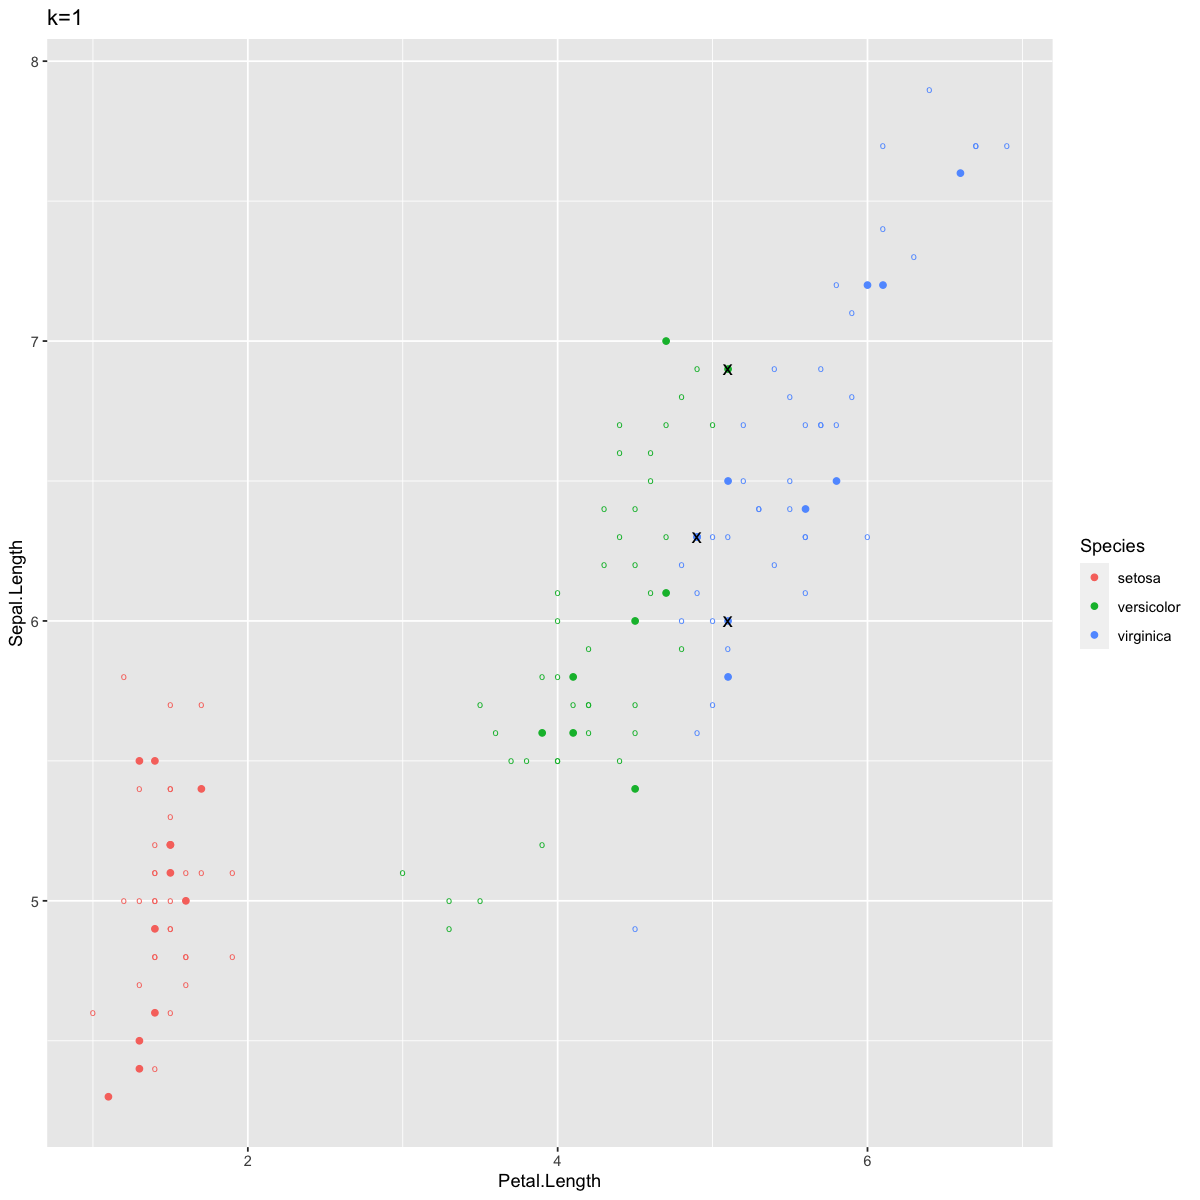

In [18]:
dat$KNN_correct <- dat$Species == dat$Species_predK1

# Base layer to show training points
ggplot(dat,aes(x=Petal.Length,y=Sepal.Length,col=Species)) + 
    geom_point(size=2,shape="o") + 
    # Next layer shows test points' KNN classifications
    geom_point(data=dat[test.inds,],
               aes(x=Petal.Length,y=Sepal.Length,col=Species_predK1)) + 
    # draw "x" over wrong ones. 
    geom_point(data=dat[which(!dat$KNN_correct),],
               aes(x=Petal.Length,y=Sepal.Length),shape="x",col="black",size=4) + 
    ggtitle("k=1")

print(paste("Accuracy:",sum(dat$KNN_correct[test.inds])/length(test.inds)))

Now we see only three misclassified points, again at the border between Versicolor and Virginica. In contexts where two clusters overlap a bit like this, `k=1` allows for points well within the Virginica cluster to be classified as Versicolor because of one stray Virginica point that just happened to be the closest item. In other words, typically `k=1` allows for too much *variance* and not enough *bias*, as discussed in lecture. **Although sometimes `k=1` can yield better predictions for very tidy clusters, larger `k` values are more robust to noisiness in your data.**

However, `k` can also be *too large*. Let's look at our predictions for `k=100`. Remember that this means each point is classified given the most common species of the 100 nearest points, and there are only 150 observations in this entire dataset.

[1] "Accuracy: 0.3"
[1] 38
[1] 41
[1] 41


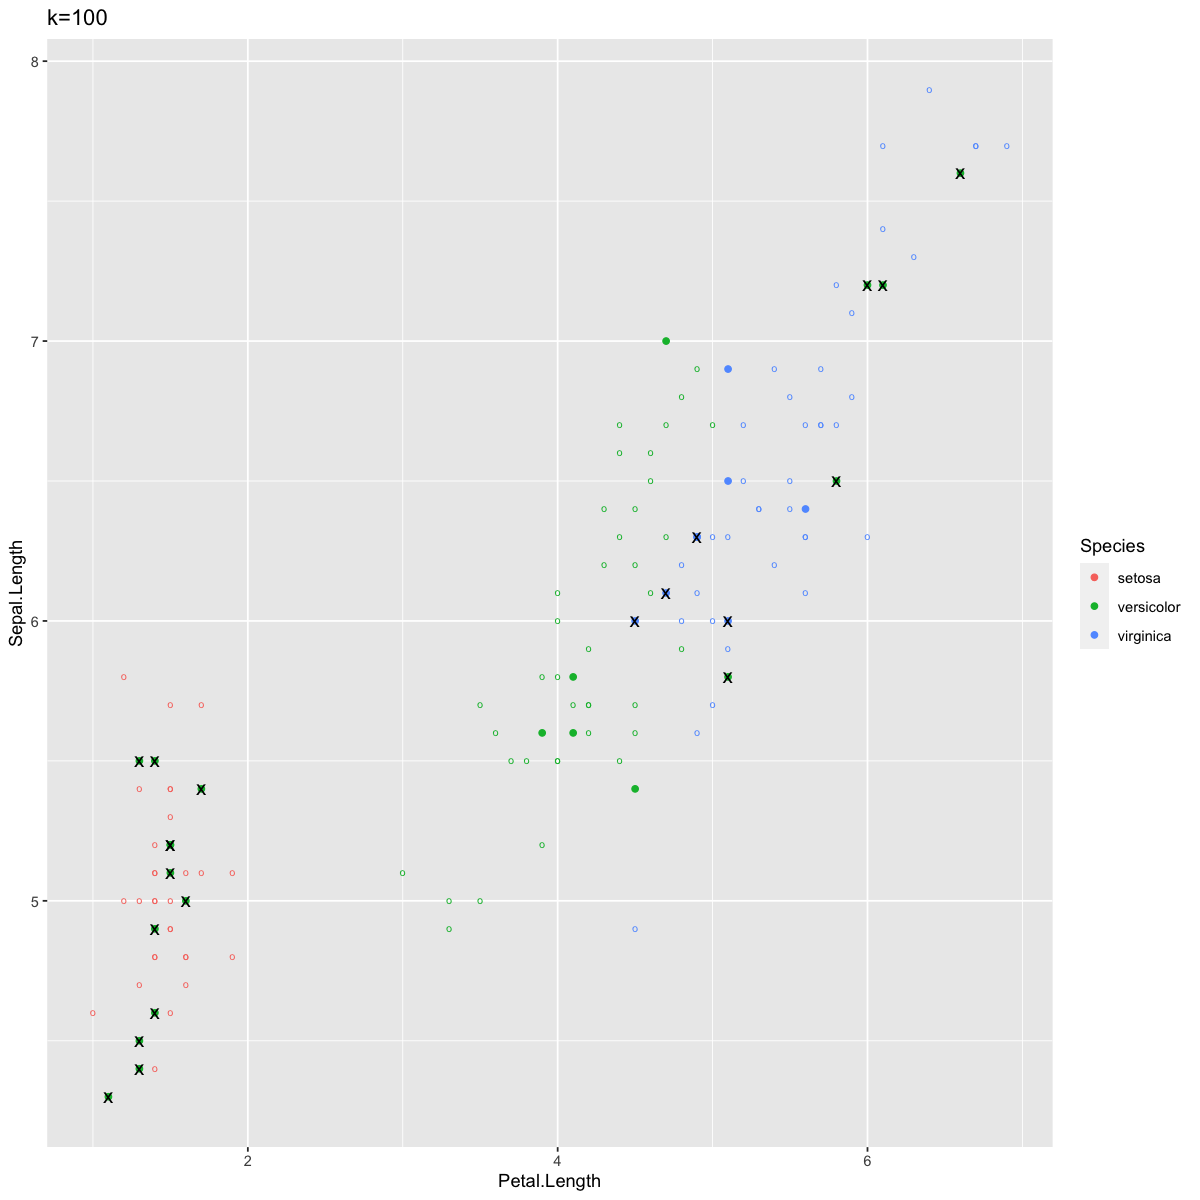

In [21]:
dat$KNN_correct <- dat$Species == dat$Species_predK100

# Base layer to show training points
ggplot(dat,aes(x=Petal.Length,y=Sepal.Length,col=Species)) + geom_point(size=2,shape="o") + 
  # Next layer shows test points' KNN classifications
  geom_point(data=dat[test.inds,],
             aes(x=Petal.Length,y=Sepal.Length,col=Species_predK100)) + 
  # draw "x" over wrong ones. 
  geom_point(data=dat[which(!dat$KNN_correct),],
             aes(x=Petal.Length,y=Sepal.Length),shape="x",col="black",size=4) + 
  ggtitle("k=100")

print(paste("Accuracy:",sum(dat$KNN_correct[test.inds])/length(test.inds)))
print(sum(dat$Species[-test.inds]=="setosa"))
print(sum(dat$Species[-test.inds]=="versicolor"))
print(sum(dat$Species[-test.inds]=="virginica"))

Here there are a lot of errors. Most notably, we now have many errors in Setosa, which previously had perfect accuracy. This is because setting `k` to 100 means you have to draw on points from much farther away, which in this case included Verginica and Versicolor observations at quite high rates. When `k=100` in this case, classification suffers from too much *bias* and not enough *variance*. 


## Standardizing data


This section will work with the Caravan dataset, which describes the demographics of thousands of individuals as well as whether or not they bought Caravan insurance (only 6% of them did). 

In [22]:
#install.packages("ISLR")
library(ISLR)

head(Caravan[,c(1:5,86)])
# column 86 is whether or not they purchased Caravan insurance

print(unique(Caravan$ABYSTAND))

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,Purchase
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,33,1,3,2,8,No
2,37,1,2,2,8,No
3,37,1,2,2,8,No
4,9,1,3,3,3,No
5,40,1,4,2,10,No
6,23,1,2,1,5,No


[1] 0 1 2


Here's the thing: some of these variables describe salary (in thousands of dollars) and others describe age (in years). Because a lot of different units of measurement are used, the variances of these variables are vastly different from each other. 

In [23]:
print(paste("variance of first variable:",var(Caravan[,1])))
print(paste("variance of second variable:",var(Caravan[,2])))

[1] "variance of first variable: 165.037847395189"
[1] "variance of second variable: 0.164707781931954"


Since KNN is based on calculations of distance, we need to **standardize** these variables so that KNN doesn't think, for example, that a difference of 60 minutes is more important than a difference of 3 years. Now let's train KNN, using `k=100` since this is a large dataset (Note: we'll talk about better ways to select proper k-values soon).

The `scale()` function transforms standardizes all selected variables, meaning they'll all have a mean of 0 and a variance of 1. We don't want to standardize our outcome variable since it is qualitative.

In [24]:
# 86 is the "Purchased" variable we will predict
stand.X <- scale(Caravan[,-86])
# variance is 1:
var(stand.X[,1])

# our test predictor variables
test.preds <- stand.X[1:1000,] 

# train predictor variables
train.preds <- stand.X[1001:nrow(stand.X),] 

# classifications for training observations
train.purch <- Caravan[1001:nrow(Caravan),86]

#run knn
test.purch.knn <- knn(train.preds,test.preds,train.purch,k=100)
print(paste("Accuracy:",mean(test.purch.knn==Caravan[1:1000,86])))

[1] 1

[1] "Accuracy: 0.941"


This seems pretty good - but then we remember that only 6% of the people in the data set even bought insurance! So you can get 94% accuracy just by guessing "No" for everyone, and that's exactly what KNN did. With so few people buying insurance, any set of 100 observations you look at will probably have majority "No". Thus we're not doing anything impressive with these predictions - make sure to think through the probability of performing "well" by chance or fluke, when you're working with classifiers!

*Notebook authored by Patience Stevens and edited by Amy Sentis and Fiona Horner.*